# 1. Calculating apatite-melt exchange coefficients (Kd) and melt water concentration 

pyAp contains a melt hygrometry model ApThermo, proposed in Li and Costa (2020, GCA) (see equations in ```pyApThermo.py```).

This file shows how to calculate exchange coefficient (Kd) and melt water contents using our package. This package also allows error propagation that is not applicable from the webpage or excel version of ApThermo. Performing the hygrometric calculation requires known F, Cl (w or w/o H$_{2}$O concentrations in apatite, and F and Cl concentrations in the melt (see details below). 

Please cite the paper below if you use this model:

Li, W. & Costa, F. (2020) A thermodynamic model for F-Cl-OH partitioning between apatite and melt including non-ideal mixing and applications to constraining melt volatile budgets, 
Geochimica et Cosmochimica Acta 269, 203–222. https://doi.org/10.1016/j.gca.2019.10.035

## Import modules and data

import releavant modules.

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pyAp import pyApthermo
from pyAp.pyAp_tools import ap_mc

### Import data

!! Do NOT change the column header names in the template excel file (provided in the same folder).

In [2]:
df = pd.read_excel('data_calc_water.xlsx')

Extract parameter values from the input file

In [3]:
order  = ['XF', 'XCL', 'T,C', 'MELTF', 'MELTCL', 'MELTCOMP']
data = df[order]  

## Calculate H$_{2}$O in the melt using apatite

### Water speciation models
Water speciation models available in this package are shown in "pyAp/water_speciation.csv" and also in `pyApThermo.py`, including:  

`dacite`            - Liu et al. 2004 

`alkali basalt`     - Lasne et al. 2010  
    
`rhyolite`          - Zhang et al. 1997  
    
`rhyolite_highP`    - Hui et al. 2008     (1 GPa)
    
`andesite`          - Ni et al. 2009  
    
`andesite_highT`    - Botcharnikov 2006   (1100-1300 ºC)

Note that model names filled in the input file (under `MELTCOMP`) should be exactly the same as those listed above. For example, "dacite" needs NOT to be written as "Dacite". 
When no model was input, the code would use the default one: `dacite` of Liu et al. (2004), DOI: 10.2138/am-2004-2-304

Additional water speciation models could be added to `pyApThermo.py`. If you would like to discuss on this with us feel free to email Alex (wl413@cam.ac.uk). 

### Calculation

You can use a Dataframe function `apply()` (see below) for iterations through each row of the input DataFrame. The data are assigned into class `Apthermo` for calculation. 

When `cal_H2O=True` (default), there will be 8 values calculated for each crystal following the order of: MeltWater calculated from F and Cl,  Kds for OH-Cl, OH-F, Cl-F, and activity coefficient (gamma) of OH, F, and Cl. 

When `cal_H2O=False`, there will be 6 values calculated for each crystal (Kds and gammas). 


In [4]:
results = pd.DataFrame()
list_result = data.apply(
    lambda row: pyApthermo.ApThermo(inputs=row[order], cal_H2O=True,cal_gamma=False).meltH2O(),axis=1
    )
results['MeltWater_calcfromF']  = [x[0] for x in list_result]
results['MeltWater_calcfromCl'] = [x[1] for x in list_result]
results['sample']               = df['sample']

results

,MeltWater_calcfromF,MeltWater_calcfromCl,sample
0,4.327077,3.373130,Ap1
1,1.465439,1.336840,Ap2
2,0.673665,0.590161,Ap3


### Save results (to csv file)

In [5]:
fn = 'outputs_melt_water.csv'
results.to_csv(fn)

## Error integration using a monte carlo (MC) algorithm

Below we show an example of estimating errors in the melt water estimates given errors in apatite composition, melt F-Cl contents, and temperature.

First, set the number of MC sampling (better to be larger than 1000)

In [6]:
mc = 1000

### Create a dataframe for storing parameter values and results from MC sampling

In [7]:
ap_mc_collect = pd.DataFrame()

comp = df[['XF', 'XCL', 'T,C', 'MELTF', 'MELTCL']]
std = df[['XF_SD', 'XCL_SD', 'T_SD','MELTF_SD', 'MELTCL_SD']]

Use function `ap_mc()` to vectorize and store values to the created empty dataframe `ap_mc_collect` 

In [8]:
for idx in range(len(df)):
    df_iter = ap_mc(comp, std, idx, mc)
    ap_mc_collect = ap_mc_collect.append(df_iter)

### Calculate melt water contents using MC samples and function `meltH2O()` in module `pyApthermo`. 

Note that `warnings.warn(msg, RuntimeWarning`) may appear if the code cannot find good solutions to some equations (in most cases because the calculated mole OH in the melt is too high). 

Considering this, in the module code we set the limit of the calculated melt water concentration to be between 0 and 15 wt% (given the range of H$_{2}$O in most silicate melts).

In [9]:
ap_mc_collect.columns = comp.columns
ap_mc_collect['MELTCOMP'] = df.loc[df.index.repeat(mc)]['MELTCOMP']
ap_mc_collect['water_estimates'] = ap_mc_collect.apply(
    lambda row: pyApthermo.ApThermo(inputs=row[order], cal_H2O=True,cal_gamma=False).meltH2O(),axis=1
    )
ap_mc_collect['sample'] = df.loc[df.index.repeat(mc)]['sample']

/Users/alexweiranli/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [10]:
results_mc = pd.DataFrame()
results_mc['MeltWater_calcfromF'] = [x[0] for x in ap_mc_collect['water_estimates']]   ## only take melt water estimates between 0 and 16wt%
results_mc['MeltWater_calcfromCl'] = [x[1] for x in ap_mc_collect['water_estimates']]  ## only take melt water estimates between 0 and 16wt%
results_mc['sample'] = ap_mc_collect.reset_index()['sample']

### Calculate mean values and uncertainties 

Calculate and show the mean and standard deviation of the melt water estimates. The median values can also be shown by adding "median" to `.agg([])` below. 

In [11]:
res = results_mc.groupby('sample').agg(['mean', 'std'])

Calculate standard deviation (half the range between 84% and 16% of all results). This is should be done if the distribution of the MC results are not Gaussian (see code below).

In [12]:
sd_F = results_mc.groupby('sample')['MeltWater_calcfromF'].transform(lambda s: (np.percentile(s, 84)-np.percentile(s, 16))/2).unique()
sd_Cl = results_mc.groupby('sample')['MeltWater_calcfromCl'].transform(lambda s: (np.percentile(s, 84)-np.percentile(s, 16))/2).unique()

### Store results in DataFrame `results`

In [13]:
results['MeltWater_Fmean']   =  [x for x in res["MeltWater_calcfromF"]["mean"]]
results['MeltWater_Fstd']   =  [x for x in res["MeltWater_calcfromF"]["std"]]
results['MeltWater_F1sd']  = [x for x in sd_F]
# # results['MeltWater_F_error,100%']  = results['MeltWater_F1sd']/results['MeltWater_Fmedian']*100

results['MeltWater_Clmean']  = [x for x in res["MeltWater_calcfromCl"]["mean"]]
results['MeltWater_Clstd']  = [x for x in res["MeltWater_calcfromCl"]["std"]]
results['MeltWater_Cl1sd'] = [x for x in sd_Cl]
# results['MeltWater_Cl_error,100%']  = results['MeltWater_Cl1sd']/results['MeltWater_Clmedian']*100


`results`: values in the leftmost two columns were calculated without considering any errors (see above), whereas the rest were calculated using the MC algorithm. 

Note that the mean values calculated from the two methods mentioned above should be identical. 

In [14]:
results

,MeltWater_calcfromF,MeltWater_calcfromCl,sample,MeltWater_Fmean,MeltWater_Fstd,MeltWater_F1sd,MeltWater_Clmean,MeltWater_Clstd,MeltWater_Cl1sd
0,4.327077,3.373130,Ap1,4.374950,0.777409,0.797939,3.631038,1.297683,NaN
1,1.465439,1.336840,Ap2,1.473224,0.236079,0.240841,1.414048,0.441805,0.410122
2,0.673665,0.590161,Ap3,0.671285,0.172851,0.183978,0.617477,0.239828,0.241775


### Plot results obtained from MC sampling

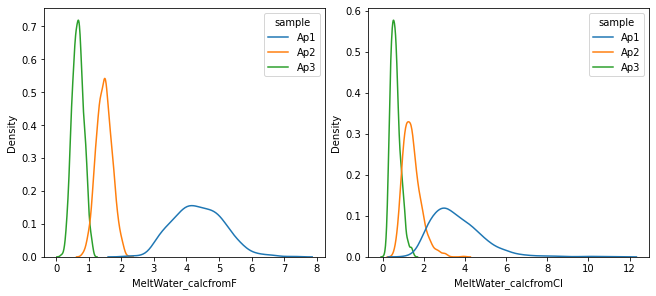

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(9,4), constrained_layout=True)

sns.kdeplot(x = 'MeltWater_calcfromF', data=results_mc, hue='sample', ax = axes[0])
sns.kdeplot(x = 'MeltWater_calcfromCl', data=results_mc, hue='sample', ax = axes[1])

plt.show()

# fig.save_fig('water_kde.jpg')